# Identification of authorized vs unauthorized vehicles

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Car Number Plate detection using VGG16 model

#### Code source
https://www.kaggle.com/tustunkok/license-plate-detection

In [0]:
import pandas as pd
import urllib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
from PIL import Image

In [3]:
from keras.applications.vgg16 import VGG16
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


### Loading manual annotation csv file

In [0]:
csv_path = '/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/'
test_data_path = '/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/'

In [5]:
csv_path

'/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/'

In [6]:
test_data_path

'/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/'

In [7]:
df = pd.read_csv(csv_path+"Car_Image_Annotations.csv")
df["image_name"] = df["image_name"]
df.head()

,image_name,top_x,top_y,bottom_x,bottom_y
0,licensed_car1.jpeg,0.523605,0.598712,0.781116,0.678112
1,licensed_car2.jpeg,0.118040,0.859688,0.536748,1.000000
2,licensed_car3.jpeg,0.217500,0.392500,0.722500,0.520000
3,licensed_car4.jpeg,0.232770,0.490885,0.423927,0.571615
4,licensed_car5.jpeg,0.110345,0.420690,0.620690,0.556322


In [8]:
df.shape

(912, 5)

### Creating a set of unseen data

In [0]:
lucky_test_samples = np.random.randint(0, len(df), 5)
reduced_df = df.drop(lucky_test_samples, axis=0)

In [10]:
lucky_test_samples

array([438, 475, 621, 192, 176])

In [11]:
reduced_df.shape

(907, 5)

In [0]:
# !pip install --upgrade matplotlib 

In [0]:
WIDTH = 224  #Size used for VVG16
HEIGHT = 224 #Size used for VVG16
CHANNEL = 3


def show_img(index):
    image = cv2.imread(test_data_path + df["image_name"].iloc[index])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, dsize=(WIDTH, HEIGHT))

    tx = int(df["top_x"].iloc[index] * WIDTH)
    print('xmin:',df["top_x"].iloc[index])
    print('xmin:',tx)
    
    ty = int(df["top_y"].iloc[index] * HEIGHT)
    print('ymin:',df["top_y"].iloc[index])
    print('ymin:',ty)
    
    bx = int(df["bottom_x"].iloc[index] * WIDTH)
    print('xmax:',df["bottom_x"].iloc[index])
    print('xmax:',bx)
    
    by = int(df["bottom_y"].iloc[index] * HEIGHT)
    print('ymax:',df["bottom_y"].iloc[index])
    print('ymax:',by)

    image = cv2.rectangle(image, (tx, ty), (bx, by), (255, 0, 0), 2) 
    plt.imshow(image)
    plt.show()


xmin: 0.286144578
xmin: 64
ymin: 0.63253012
ymin: 141
xmax: 0.656626506
xmax: 147
ymax: 0.7198795179999999
ymax: 161


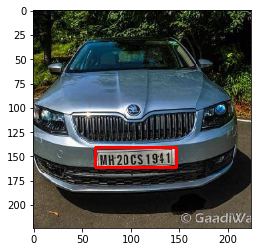

In [14]:
# our image with manual annotation
show_img(313)

In [0]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

In [16]:
test_data_path

'/content/drive/My Drive/AIML/GL AIML Capstone/Final/Data/Car Annotated Images/'

### Creating Training and Test set

In [17]:
train_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=test_data_path,
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="training")

validation_generator = datagen.flow_from_dataframe(
    reduced_df,
    directory=test_data_path,
    x_col="image_name",
    y_col=["top_x", "top_y", "bottom_x", "bottom_y"],
    target_size=(WIDTH, HEIGHT),
    batch_size=32, 
    class_mode="other",
    subset="validation")

Found 817 validated image filenames.
Found 90 validated image filenames.


### Creating VGG16 Model 

In [18]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(WIDTH,HEIGHT,CHANNEL))) # changed the order of width and height
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()





58892288/58889256 [==============================] - 6s 0us/step






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 260       
Total params: 17,938,756
Trainable params: 3,

In [19]:
STEP_SIZE_TRAIN = int(np.ceil(train_generator.n / train_generator.batch_size))
STEP_SIZE_VAL = int(np.ceil(validation_generator.n / validation_generator.batch_size))

print("Train step size:", STEP_SIZE_TRAIN)
print("Validation step size:", STEP_SIZE_VAL)

train_generator.reset()
validation_generator.reset()

Train step size: 26
Validation step size: 3


In [20]:
adam = Adam(lr=0.0005)
model.compile(optimizer=adam, loss="mse")

In [21]:
history = model.fit_generator(train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_data=validation_generator,
    validation_steps=STEP_SIZE_VAL,
    epochs=30)



Epoch 1/30
26/26 [==============================] - 310s 12s/step - loss: 0.0116 - val_loss: 0.0046
Epoch 2/30
26/26 [==============================] - 29s 1s/step - loss: 0.0022 - val_loss: 0.0016
Epoch 3/30
26/26 [==============================] - 30s 1s/step - loss: 8.4058e-04 - val_loss: 7.0743e-04
Epoch 4/30
26/26 [==============================] - 30s 1s/step - loss: 4.8050e-04 - val_loss: 4.6168e-04
Epoch 5/30
26/26 [==============================] - 30s 1s/step - loss: 2.9498e-04 - val_loss: 2.9303e-04
Epoch 6/30
26/26 [==============================] - 31s 1s/step - loss: 1.7973e-04 - val_loss: 2.7790e-04
Epoch 7/30
26/26 [==============================] - 30s 1s/step - loss: 2.0383e-04 - val_loss: 1.8935e-04
Epoch 8/30
26/26 [==============================] - 30s 1s/step - loss: 1.5170e-04 - val_loss: 2.1393e-04
Epoch 9/30
26/26 [==============================] - 30s 1s/step - loss: 1.6016e-04 - val_loss: 1.7746e-04
Epoch 10/30
26/26 [==============================] - 30s 1

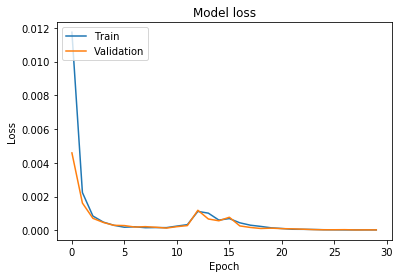

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Model evaluation

In [23]:
model.evaluate_generator(validation_generator, steps=STEP_SIZE_VAL)

2.162202929159523e-05

### Saving Model and weights

In [24]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/drive/My Drive/AIML/GL AIML Capstone/Final/Code/VGG16 & SVM Model/Car_Number_Plate_Detection_VGG16_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("/content/drive/My Drive/AIML/GL AIML Capstone/Final/Code/VGG16 & SVM Model/Car_Number_Plate_Detection_VGG16_model_weights.h5")
print("Saved model to disk")


Saved model to disk


### Model prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


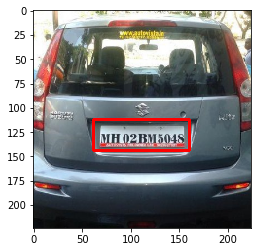

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


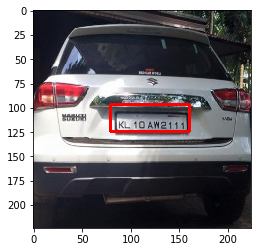

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


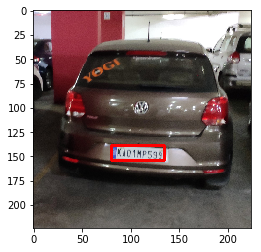

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


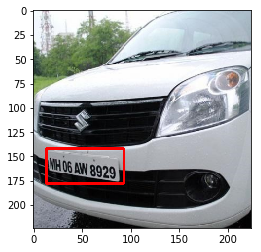

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


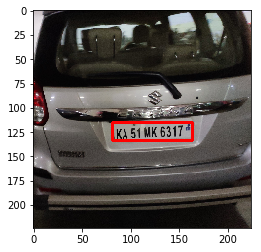

In [25]:
for idx, row in df.iloc[lucky_test_samples].iterrows():    
    img = cv2.resize(cv2.imread(test_data_path + row[0]) / 255.0, dsize=(WIDTH, HEIGHT))
   
    y_hat = model.predict(img.reshape(1, WIDTH, HEIGHT, 3)).reshape(-1) * WIDTH
    
    xt, yt = y_hat[0], y_hat[1]
    xb, yb = y_hat[2], y_hat[3]
    
    img = cv2.cvtColor(img.astype(np.float32), cv2.COLOR_BGR2RGB)
    image = cv2.rectangle(img, (xt, yt), (xb, yb), (255, 0, 0), 2) # changed from (0, 0, 255), 1
    plt.imshow(image)
    plt.show()